In [1]:
import os
import scipy.io
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from scipy.stats import linregress
import umap.umap_ as umap
import seaborn as sns
from itertools import cycle, islice

## Фильтрация и преподготовка.
Данные можно скачать [здесь](https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)

Эти данные  &mdash;  датасет переферических клеток крови (в основном &mdash;  лимфоциты и моноциты, клетки имунной системы), где каждая строчка  &mdash;  это отдельный ген, каждый столбец &mdash;  отдельная клетка. Дополнительно к этому датасету идут два файла, с названиями генов и индексами клеток. Наша задача сегодня будет понять, из каких кластеров состоят наши данные и сможем ли мы выделить биологически осмысленные группы.

In [2]:
matrix_dir = "./"

In [3]:
genes_path = os.path.join(matrix_dir, "genes.tsv")
matrix_path = os.path.join(matrix_dir, "matrix.mtx")
barcodes_path = os.path.join(matrix_dir, "barcodes.tsv")

In [4]:
# Загружаем матрицу, баркоды, аннотацию для генов

mat = np.array(scipy.io.mmread(matrix_path).todense()) 
annotation = pd.read_csv(genes_path, sep='\t',header=None)
annotation.columns = ['ensemble_id','gene_symbol']
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T  # хотим матрицу размера (samples, features) 

Посмотрим на загруженные объекты:

In [5]:
mat.shape, len(barcodes), annotation.shape

((2700, 32738), 2700, (32738, 2))

In [6]:
annotation.head()

,ensemble_id,gene_symbol
0,ENSG00000243485,MIR1302-10
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5
3,ENSG00000238009,RP11-34P13.7
4,ENSG00000239945,RP11-34P13.8


In [7]:
mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
barcodes[1:5]

['AAACATTGAGCTAC-1',
 'AAACATTGATCAGC-1',
 'AAACCGTGCTTCCG-1',
 'AAACCGTGTATGCG-1']

Строим распределение суммарного количества транскриптов в каждой клетке и для каждого гена в логарифмических координатах. 
Для каждого из распределений считаем также среднее, медиану и среднеквадратичное отклонение.

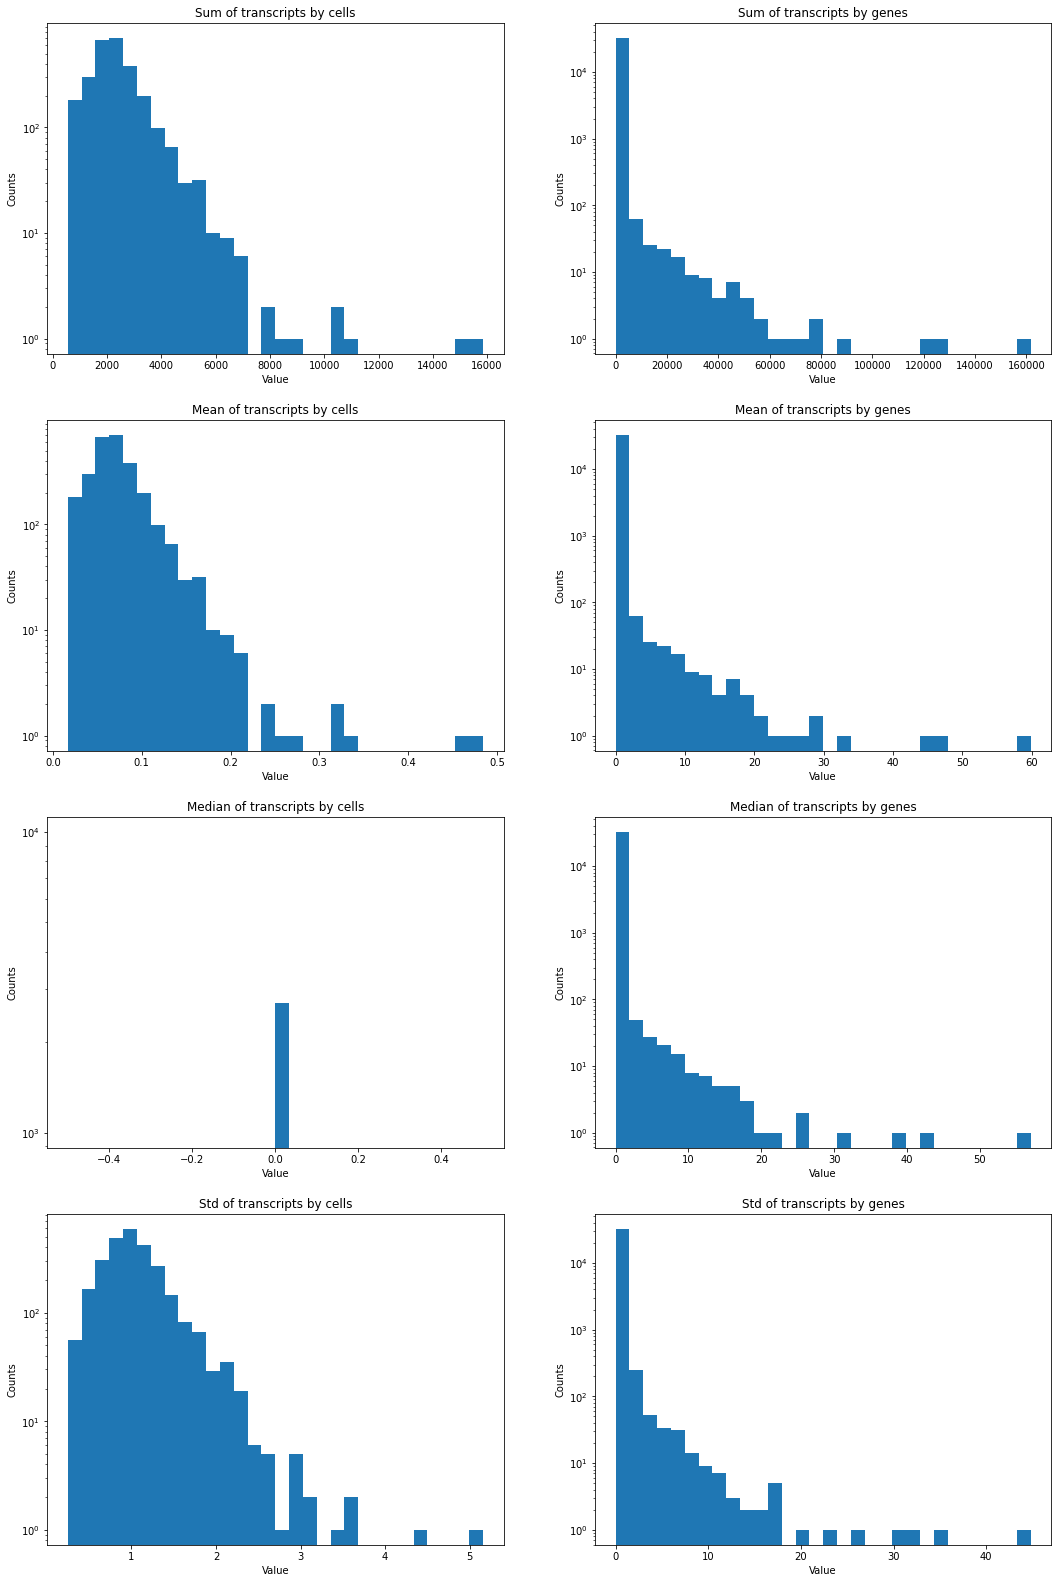

In [9]:
cells = [mat.sum(axis = 1),mat.mean(axis = 1),
           np.median(mat,axis = 1),mat.std(axis = 1)]
genes = [mat.sum(axis = 0),mat.mean(axis = 0),
           np.median(mat,axis = 0),mat.std(axis = 0)]
names = ['Sum of transcripts','Mean of transcripts',
         'Median of transcripts', 'Std of transcripts']
i = 1
plt.figure(figsize = (18,28))
for cell, gene, name in zip(cells,genes,names):
    plt.subplot(4,2,i)
    i+=1
    plt.hist(cell, bins = 30, log = True)
    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.title(name + ' by cells')
    plt.subplot(4,2,i)
    i+=1
    plt.hist(gene, bins = 30, log = True)
    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.title(name + ' by genes');

Распределения суммы, среднеквадратичного отклонения и среднего по клеткам похожи на хи квадрат, медиана же у всех просто равна нулю, вероятно из-за слишком большого количества генов которые не транскрибировались. По генам же везде похоже на экспоненциальное распределение.

Убераем из датасета клетки с суммарной экспрессией менее 250 или более чем 5000. Эти клетки, предположительно, выбросы.

In [10]:
mat = pd.DataFrame(mat, columns = annotation.ensemble_id)
thesum = mat.agg(sum, axis = 'columns')
mat = mat[(250<thesum) & (thesum<5000)]

#### Шаг 4: Нормализация данных.

Следующий этап &mdash; нормализация данных. Для этого делим значения экспрессии каждой клетки на сумму экспрессий, умножаем на константу (10000) и берем логарифм.
Число 10000 здесь используется для вычислительной стабильности, оно не несет какого то смысла. Формально это означает, что мы стандартизировали экспрессию каждой клетки &mdash; теперь все клетки экспрессируют 10000 РНК.

In [11]:
thesum = mat.agg(sum, axis = 0)
matnew = np.log(1 + (mat/thesum)*10000)

Работать с таким количество признаков достаточно тяжело, поэтому выберем наиболее вариабельные гены. Процедура ниже часто применяется для выбора вариабельных генов.

Другими словами, это гены, дисперсия значений которых значительно больше, чем можно было бы ожидать по их средней экспрессии. Мы предполагаем, что именно такие гены будут нести информацию, так как нам не нужны гены, которые экспрессируются на одном уровне по всех клетках &mdash; они не помогут нам разделить кластеры.   

1) Для начала посчитаем стандартное отклонение и среднее по "сырым" данным, отбросим гены, где они равны нулю.  

In [12]:
thesum = None
matnew = matnew.loc[:,(mat.mean(axis = 0) != 0 )& (mat.std(axis = 0) != 0)]
mat = mat.loc[:,(mat.mean(axis = 0) != 0 )& (mat.std(axis = 0) != 0)]

2) Построим линейную модель, где зависимая переменная  &mdash; стандартное отклонение гена, а предиктор &mdash; среднее значение экспрессии. Постройте график зависимости и наблюдений. Посчитаем предсказание отклонения для каждого гена и метрики качества.


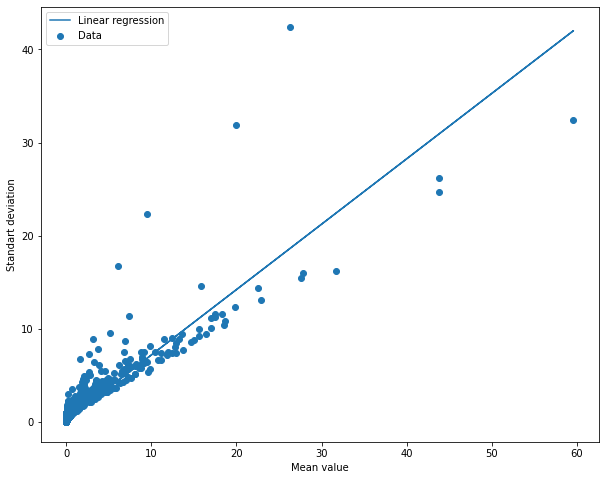

In [13]:
x,y = mat.mean(axis = 0),mat.std(axis = 0)
lnr = linregress(x,y)
pred = lnr.slope*x + lnr.intercept
plt.figure(figsize = (10,8))
plt.plot(x,pred,label = "Linear regression")
plt.scatter(x,y, label = "Data")
plt.xlabel('Mean value')
plt.ylabel("Standart deviation")
plt.legend();

3) Следующий этап &mdash; нормализация данных. Для этого из матрицы с сырыми данными вычтем среднее для каждого гена, поделим на стандартное отклонение, но не посчитанное по данным, а на предсказанное моделью. Мы получим нормализованную версию таблицы. Если бы мы делили на выборочное стандартное отклонение, то в этой нормализованной версии таблицы стандартное отклонение каждого гена было бы равно 1. Тут же это не так. 

In [14]:
mat = (mat - x)/pred

4) Посчитайте стандартное отклонение каждого гена в нормализованной версии, постройте график, где по оси x располагается  логарифм средней экспрессии, а по оси y &mdash; посчитанное отклонение.   


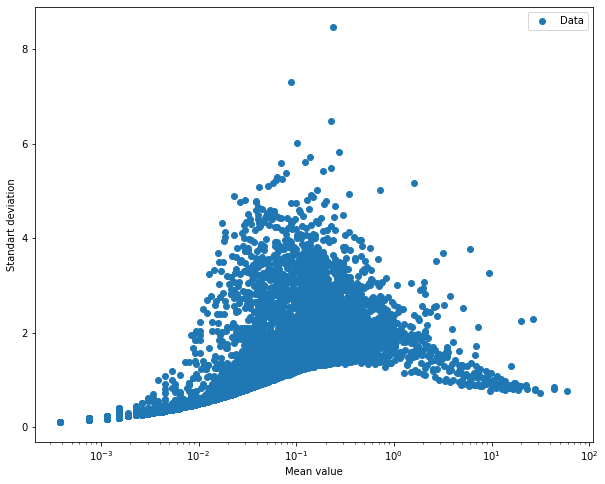

In [15]:
y = mat.std(axis = 0)
plt.figure(figsize = (10,8))
plt.scatter(x,y, label = "Data")
plt.xscale('log')
plt.xlabel('Mean value')
plt.ylabel("Standart deviation")
plt.legend();

5) Отсортируем гены по этому отклонению, выберем первые 2000.

In [16]:
names = y.sort_values(ascending=False).iloc[:2000].index
ringbrotherhood = matnew.loc[:,names]

#### Шаг 6: Понижение размерности
Несмотря на то, что мы отобрали крайне вариабельные гены, они вполне могут быть скоррелированны, поэтому мы хотим найти новые "координаты", которых меньше, но которые почти так же хорошо описывают наши данные. 

0. Отмасштабируем данные (выбранные гены).
1. Обучим PCA.
2. Построим график доли объясненной варации.

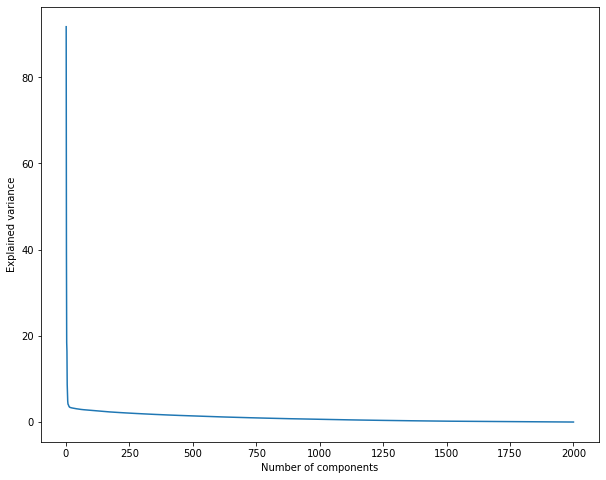

In [20]:
matscaled = scale(ringbrotherhood.to_numpy())
pca = PCA()
compressedmat = pca.fit_transform(matscaled)
y = pca.explained_variance_
x = 1+np.arange(pca.n_components_)
plt.figure(figsize = (10,8))
plt.plot(x,y)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

#### Шаг 7: Эмбеддинг в двумерное пространство. 
Для этого воспользуемся UMAP с параметрами n_neighbors=25, min_dist=0.5, learning_rate=0.5, metric='euclidean' и его методом fit_transform.

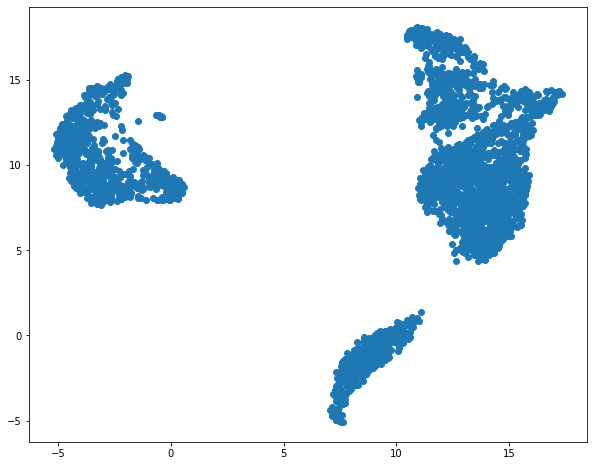

In [23]:
compressedmat = PCA(n_components = 15).fit_transform(matscaled)
matUMAP = umap.UMAP(n_neighbors = 25,
               min_dist = 0.5, learning_rate=0.5,
               metric='euclidean' ).fit_transform(compressedmat)
plt.figure(figsize = (10,8))
plt.scatter(matUMAP[:,0],matUMAP[:,1])

#### Шаг 8: кластеризация клеток

Ваша задача &mdash; попробовать различные кластеризации. Кластеризовать будем в выбранном пространстве после PCA, наносить на двумерное пространство после UMAP. Так как у нас никакой информации, как должны выглядеть
кластеры, то попробуем разные методы и посмотрим, как выглядит кластеризация.

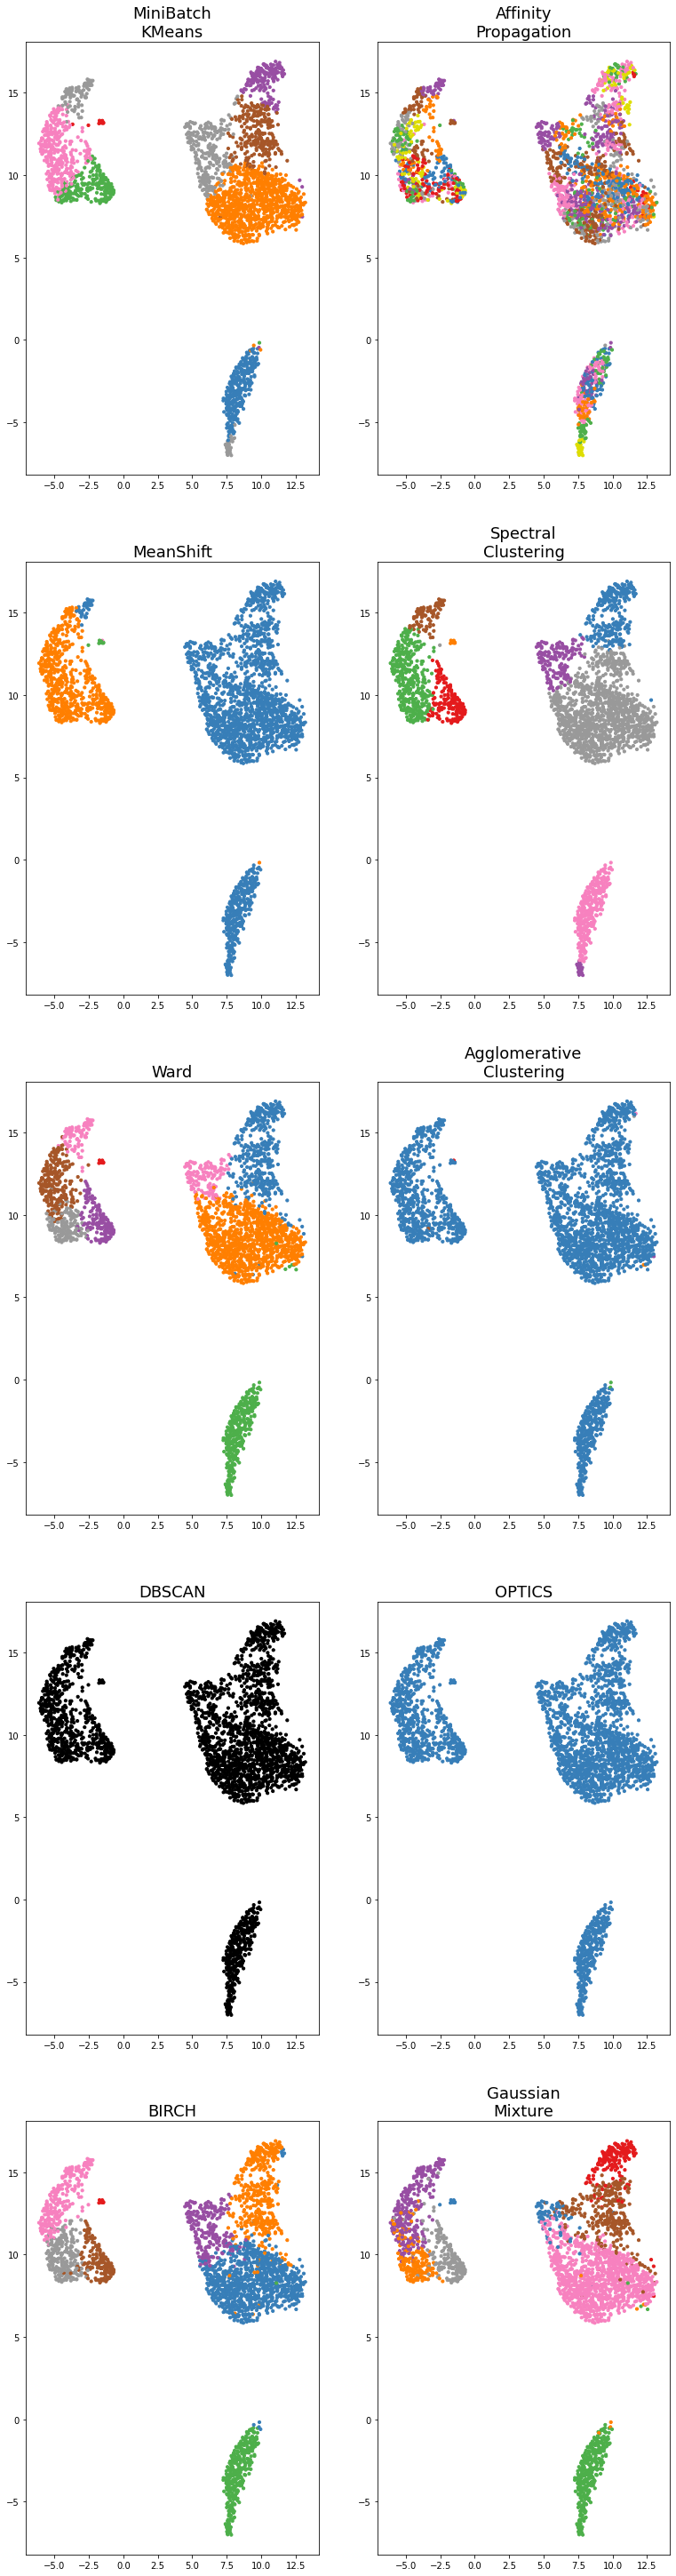

In [27]:
def clap_clap(X):
    plt.figure(figsize=(13,52))
    plot_num = 1
    predicted = {}
    params = {"quantile": 0.3,
              "eps": 0.3,
              "damping": 0.9,
              "preference": -200,
              "n_neighbors": 15,
              "n_clusters": 8,
              "min_samples": 20,
              "xi": 0.05,
              "min_cluster_size": 0.1}
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )
    X1 = umap.UMAP(n_neighbors = 25,
            min_dist = 0.5, learning_rate=0.5,
            metric='euclidean' ).fit_transform(X)
    for name, algorithm in clustering_algorithms:
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(5, 2, plot_num)
        plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X1[:, 0], X1[:, 1], s=10, color=colors[y_pred])
        plot_num += 1
        predicted.update({name:y_pred})
    return predicted
    plt.show()
predicted = clap_clap(compressedmat)

#### Визуализация экспрессии маркеров.

In [31]:
cluster_assignment = dict({'Memory CD4+':['IL7R', 'CCR7'],
                          'Naive CD4+ T' : ['IL7R', 'S100A4'],
                          'CD14+ Mono':['LYZ','CD14'],
                          'B':['MS4A1'],
                          'CD8+ T':['CD8A'],
                          'FCGR3A+ Mono':['FCGR3A','MS4A7'],
                          'NK':['GNLY','NKG7'],
                          'DC':['FCER1A','CST3'],
                          'Mk':['PPBP']}) # гены, характерные для типов клеток

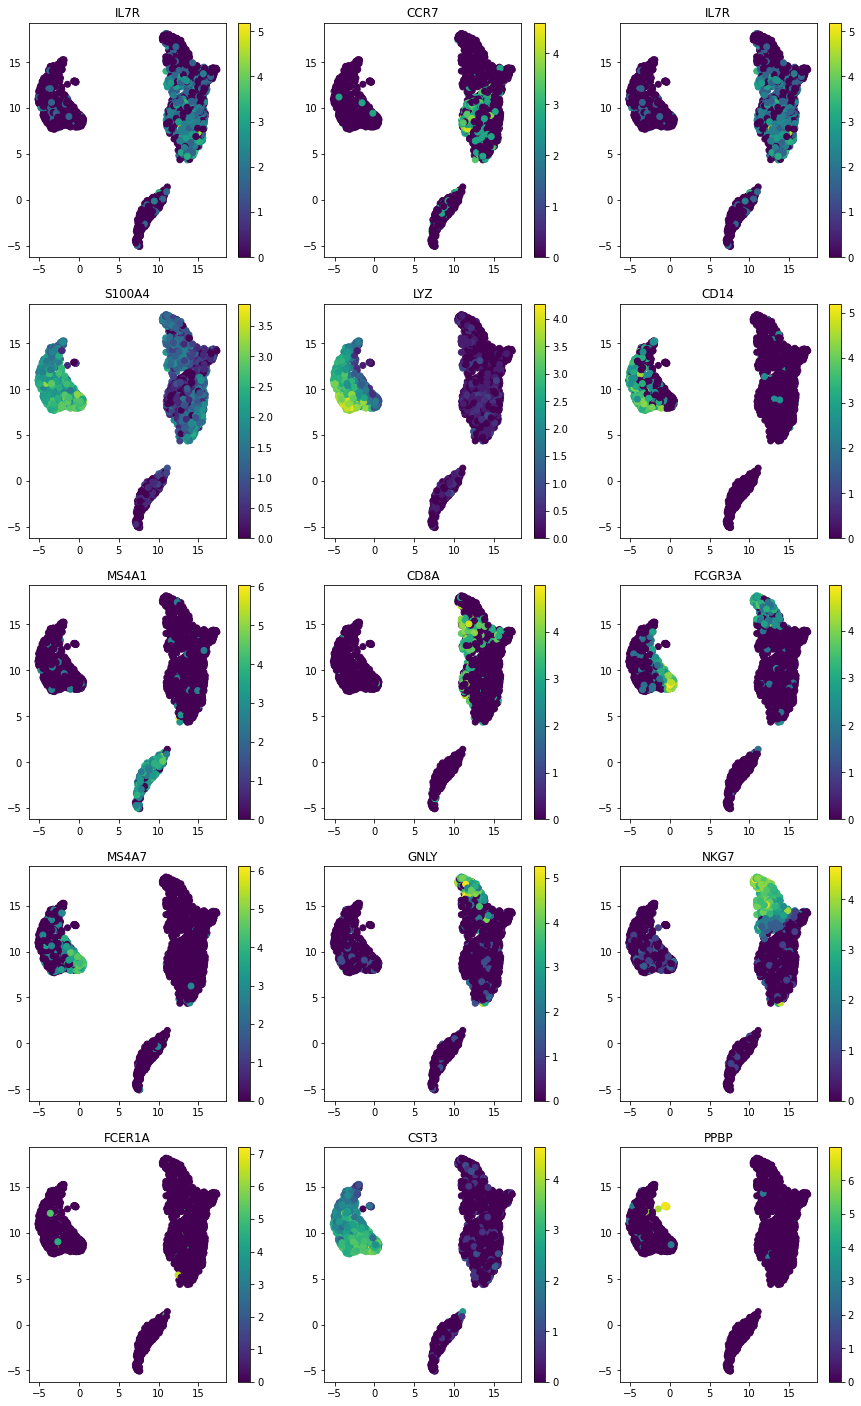

In [46]:
#annotation = annotation.set_index('gene_symbol')
n = 1
plt.figure(figsize=(15,25))
for name in cluster_assignment:
    gene_ids = cluster_assignment[name]
    for gene in gene_ids:
        newname = annotation.loc[gene, 'ensemble_id']
        plt.subplot(5, 3, n)
        n+=1
        plt.scatter(matUMAP[:,0],matUMAP[:,1], c = matnew[newname])
        plt.title(gene)
        #plt.legend()
        plt.colorbar()
plt.show()